In [2]:
import sys
sys.path.append('../..')

import pandas as pd
import ccxt
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import matplotlib.pyplot as plt

from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, get_metrics, get_n_columns, plot_sharpe_evolution, plot_bar_by_month
from utilities.get_data import get_historical_from_db
import ta


In [3]:
pair = "ADA/USDT"
tf = "1d"

df = get_historical_from_db(
    ccxt.binance(), 
    pair,
    tf,
    path="../../database/"
)

training_set = df.copy().loc[:"2020"]
test_set = df.copy().loc["2021":]
learn_period = 7

training_set

,open,high,low,close,volume
date,,,,,
2018-04-17,0.25551,0.28800,0.23983,0.24260,6.746229e+07
2018-04-18,0.24260,0.26460,0.24201,0.26200,3.132810e+07
2018-04-19,0.26199,0.27500,0.25777,0.27004,5.085998e+07
2018-04-20,0.27004,0.30442,0.26648,0.30108,7.108428e+07
2018-04-21,0.30161,0.30700,0.26509,0.28668,9.271984e+07
...,...,...,...,...,...
2020-12-27,0.15839,0.16642,0.14936,0.15467,7.981346e+08
2020-12-28,0.15467,0.18057,0.15280,0.17627,8.815477e+08
2020-12-29,0.17630,0.19725,0.17304,0.19067,1.475501e+09


In [4]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set["close"].values.reshape(-1, 1))

X_train = []
y_train = []

for i in range(learn_period, len(training_set)):
    X_train.append(training_set_scaled[i-learn_period:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train[0][0:2]

array([[0.62893605],
       [0.68457126]])

In [5]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
31/31 [==============================] - 8s 15ms/step - loss: 0.0166
Epoch 2/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0030
Epoch 3/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0025
Epoch 4/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0021
Epoch 5/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0022
Epoch 6/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0023
Epoch 7/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0023
Epoch 8/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0024
Epoch 9/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0021
Epoch 10/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0023
Epoch 11/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0021
Epoch 12/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0020
Epoch 13/50
31/31 [==================

In [6]:
real_stock_price = test_set.iloc[:, 1:2].values

dataset_total = pd.concat((training_set['close'], test_set['close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_set) - learn_period:].values
inputs = inputs.reshape(-1,1)
inputs = sc.fit_transform(inputs)
X_test = []
for i in range(learn_period, len(test_set) + learn_period):
    X_test.append(inputs[i-learn_period:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

23/23 [==============================] - 2s 8ms/step


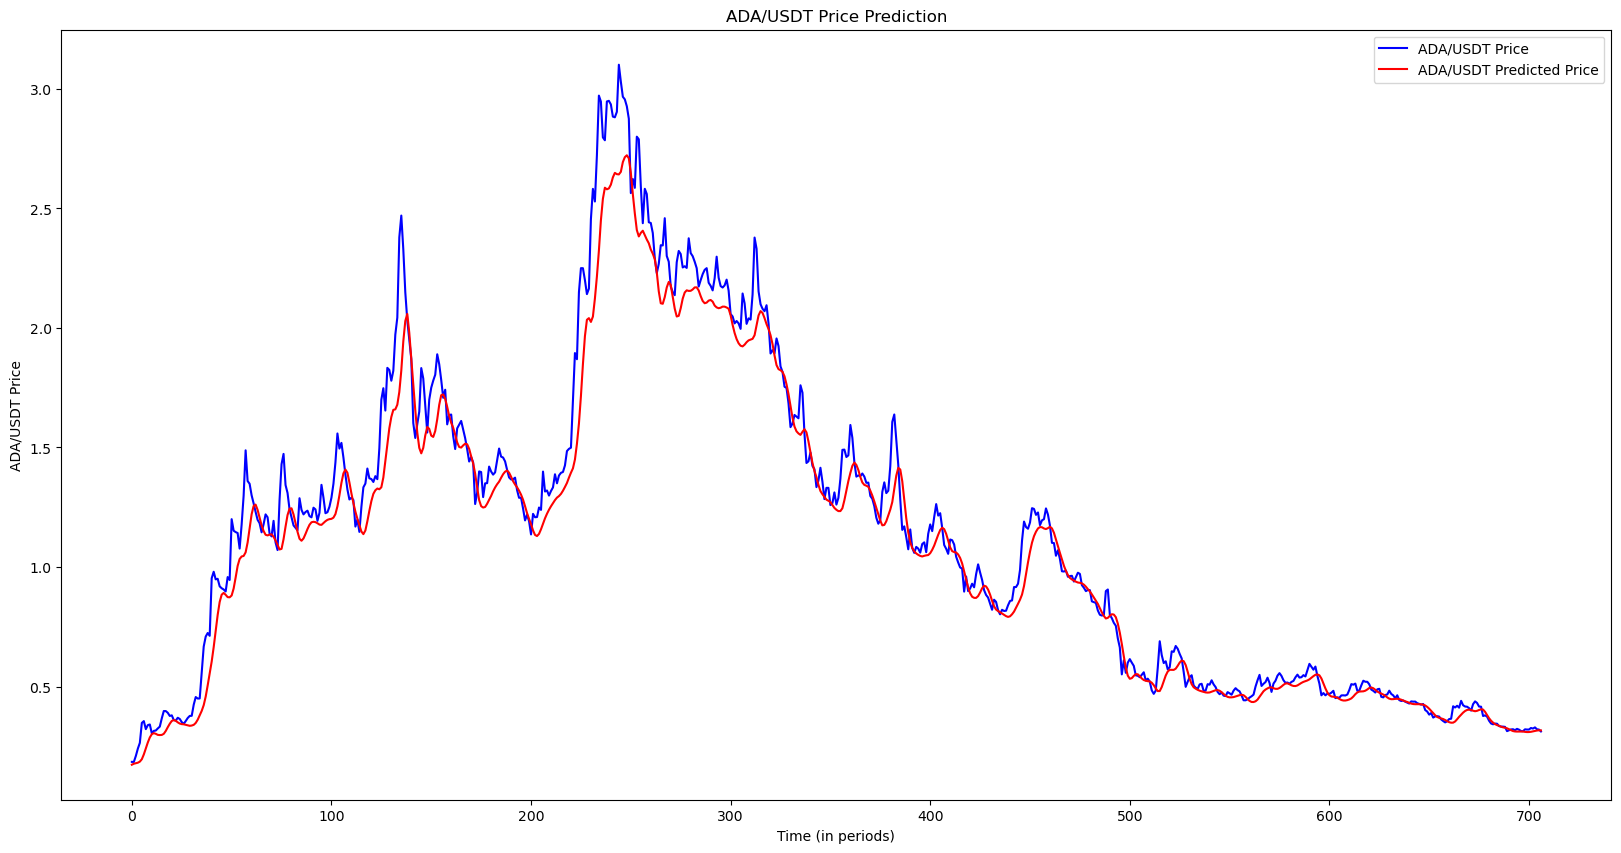

In [7]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'blue', label = pair + ' Price')
plt.plot(predicted_stock_price, color = 'red', label = pair + ' Predicted Price')
plt.title(pair +' Price Prediction')
plt.xlabel('Time (in periods)')
plt.ylabel(pair + ' Price')
plt.legend()
plt.show()

In [8]:
df["predicted"] = 0
df["predicted"].iloc[-len(predicted_stock_price.flatten()):] = predicted_stock_price.flatten()
df["diff_close"] = df["close"].diff()
df["diff_predicted"] = df["predicted"].diff()
df["next_predicted"] = df["predicted"].shift(-1)
df["next_close"] = df["close"].shift(-1)
df["diff_predicted_next"] = df["next_predicted"] - df["predicted"]
df["diff_close_next"] = df["next_close"] - df["close"]
df["mean_evol_3"] = df["close"].shift(-3).rolling(3).mean() - df["close"]
df["mean_evol_5"] = df["close"].shift(-5).rolling(5).mean() - df["close"]
df["mean_evol_10"] = df["close"].shift(-10).rolling(10).mean() - df["close"]
df["mean_evol_20"] = df["close"].shift(-20).rolling(20).mean() - df["close"]
df

C:\Users\jacks\AppData\Local\Temp\ipykernel_29660\2249266855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["predicted"].iloc[-len(predicted_stock_price.flatten()):] = predicted_stock_price.flatten()


,open,high,low,close,volume,predicted,diff_close,diff_predicted,next_predicted,next_close,diff_predicted_next,diff_close_next,mean_evol_3,mean_evol_5,mean_evol_10,mean_evol_20
date,,,,,,,,,,,,,,,,
2018-04-17,0.25551,0.28800,0.23983,0.24260,67462293.24,0.000000,NaN,NaN,0.000000,0.26200,0.000000,0.01940,NaN,NaN,NaN,NaN
2018-04-18,0.24260,0.26460,0.24201,0.26200,31328095.79,0.000000,0.01940,0.000000,0.000000,0.27004,0.000000,0.00804,NaN,NaN,NaN,NaN
2018-04-19,0.26199,0.27500,0.25777,0.27004,50859980.22,0.000000,0.00804,0.000000,0.000000,0.30108,0.000000,0.03104,0.019747,NaN,NaN,NaN
2018-04-20,0.27004,0.30442,0.26648,0.30108,71084276.49,0.000000,0.03104,0.000000,0.000000,0.28668,0.000000,-0.01440,-0.015693,NaN,NaN,NaN
2018-04-21,0.30161,0.30700,0.26509,0.28668,92719842.91,0.000000,-0.01440,0.000000,0.000000,0.28160,0.000000,-0.00508,0.005990,0.001314,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-04,0.31960,0.32410,0.31810,0.32210,58073868.40,0.312161,0.00250,0.001616,0.314133,0.31930,0.001972,-0.00280,-0.006167,NaN,NaN,NaN
2022-12-05,0.32220,0.32900,0.31630,0.31930,68934870.60,0.314133,-0.00280,0.001972,0.315889,0.31830,0.001756,-0.00100,-0.006467,NaN,NaN,NaN
2022-12-06,0.31930,0.32110,0.31350,0.31830,54889434.10,0.315889,-0.00100,0.001756,0.316807,0.31020,0.000918,-0.00810,NaN,NaN,NaN,NaN


In [9]:
print(len(df.loc[(df["diff_predicted_next"] > df["diff_close"]) & (df["diff_close_next"] > 0)]))
print(len(df.loc[(df["diff_predicted_next"] > df["diff_close"]) & (df["diff_close_next"] < 0)]))
print("-------------")
print(len(df.loc[(df["diff_predicted_next"] < df["diff_close"]) & (df["diff_close_next"] < 0)]))
print(len(df.loc[(df["diff_predicted_next"] < df["diff_close"]) & (df["diff_close_next"] > 0)]))
print("-------------")
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["diff_close_next"].mean())
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["mean_evol_3"].mean())
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["mean_evol_5"].mean())
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["mean_evol_10"].mean())
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["mean_evol_20"].mean())
print("-------------")
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["diff_close_next"].mean())
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["mean_evol_3"].mean())
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["mean_evol_5"].mean())
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["mean_evol_10"].mean())
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["mean_evol_20"].mean())

455
392
-------------
453
391
-------------
0.000660011764705881
0.0012895754716981617
0.001768306965761509
0.003082289786223273
0.004030201564380267
-------------
-0.0006077251184834117
-0.0012233096085408823
-0.0016716071428571453
-0.0032250946107784365
-0.003649974576271181


In [10]:
print(len(df.loc[(df["diff_predicted"] > 0) & (df["diff_close"] > 0)]))
print(len(df.loc[(df["diff_predicted"] > 0) & (df["diff_close"] < 0)]))
print("-------------")
print(len(df.loc[(df["diff_predicted"] < 0) & (df["diff_close"] < 0)]))
print(len(df.loc[(df["diff_predicted"] < 0) & (df["diff_close"] > 0)]))
print("-------------")
print(df.loc[(df["diff_predicted"] > 0)]["diff_close_next"].mean())
print(df.loc[(df["diff_predicted"] > 0)]["mean_evol_3"].mean())
print(df.loc[(df["diff_predicted"] > 0)]["mean_evol_5"].mean())
print(df.loc[(df["diff_predicted"] > 0)]["mean_evol_10"].mean())
print(df.loc[(df["diff_predicted"] > 0)]["mean_evol_20"].mean())
print("-------------")
print(df.loc[(df["diff_predicted"] < 0)]["diff_close_next"].mean())
print(df.loc[(df["diff_predicted"] < 0)]["mean_evol_3"].mean())
print(df.loc[(df["diff_predicted"] < 0)]["mean_evol_5"].mean())
print(df.loc[(df["diff_predicted"] < 0)]["mean_evol_10"].mean())
print(df.loc[(df["diff_predicted"] < 0)]["mean_evol_20"].mean())

160
167
-------------
189
189
-------------
0.0022880428134556536
0.006069948717948817
0.009890606811145515
0.013214015576324007
0.01915486677115984
-------------
-0.0016181530343007888
-0.004502339489885532
-0.007447598944591038
-0.010074367021276592
-0.015271637228260857


In [11]:
class lstm_strat():
    def __init__(
        self,
        df,
        use_short=True,
        strat=0,
    ):
        self.df = df
        self.use_short = use_short
        self.strat = strat
        
    def populate_indicators(self, show_log=False):
        # -- Clear dataset --
        df = self.df
        df.drop(columns=df.columns.difference(['open','high','low','close','volume', "predicted"]), inplace=True)
        
        # -- Populate indicators --
        df["diff_close"] = df["close"].diff()
        df["diff_predicted"] = df["predicted"].diff()
        df["next_predicted"] = df["predicted"].shift(-1)
        df["diff_predicted_next"] = df["next_predicted"] - df["predicted"]
        
        # -- Log --
        if(show_log):
            print(df)
        
        self.df = df    
        return self.df
    
    def populate_buy_sell(self, show_log=False): 
        df = self.df
        # -- Initiate populate --
        df["open_long_market"] = False
        df["close_long_market"] = False
        df["open_short_market"] = False
        df["close_short_market"] = False
        
        if self.strat == 0:
            # -- Populate open long market --
            df.loc[
                (df['diff_predicted'] > 0)
                , "open_long_market"
            ] = True
            
            # -- Populate close long market --
            df.loc[
                (df['diff_predicted'] < 0) 
                , "close_long_market"
            ] = True
            
            if self.use_short:
                # -- Populate open short market --
                df.loc[
                    (df['diff_predicted'] < 0) 
                    , "open_short_market"
                ] = True
                
                # -- Populate close short market --
                df.loc[
                    (df['diff_predicted'] > 0) 
                    , "close_short_market"
                ] = True

        elif self.strat == 1:
            # -- Populate open long market --
            df.loc[
                (df['diff_predicted_next'] > df['diff_close'])
                , "open_long_market"
            ] = True
            
            # -- Populate close long market --
            df.loc[
                (df['diff_close'] > df['diff_predicted_next']) 
                , "close_long_market"
            ] = True
            
            if self.use_short:
                # -- Populate open short market --
                df.loc[
                    (df['diff_close'] > df['diff_predicted_next']) 
                    , "open_short_market"
                ] = True
                
                # -- Populate close short market --
                df.loc[
                    (df['diff_predicted_next'] > df['diff_close']) 
                    , "close_short_market"
                ] = True
            
        
        # -- Log --
        if(show_log):
            print("Open LONG length :",len(df.loc[df["open_long_market"]==True]))
            print("Close LONG length :",len(df.loc[df["close_long_market"]==True]))
            print("Open SHORT length :",len(df.loc[df["open_short_market"]==True]))
            print("Close SHORT length :",len(df.loc[df["close_short_market"]==True]))
        
        self.df = df   
        return self.df
        
    def run_backtest(self, initial_wallet=1000, return_type="metrics"):
        dt = self.df[:]
        wallet = initial_wallet
        maker_fee = 0
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        # print("tp",take_profit_pct,"sl",stop_loss_pct)
        
        for index, row in dt.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":
                        
                    # -- Close LONG market --
                    if row['close_long_market']:
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None
                        
                elif current_position['side'] == "SHORT":
                    # -- Close SHORT Market --
                    if row['close_short_market']:
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "SHORT",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size": current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check for opening position --
            else:
                # Open long market
                if row['open_long_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                elif row['open_short_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT"
                    }
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
        df_trades = df_trades.set_index(df_trades['open_date'])   
        
        if return_type == "metrics":
            return get_metrics(df_trades, df_days) | {
                "wallet": wallet,
                "trades": df_trades,
                "days": df_days
            }  
        else:
            return True    
        

Period: [2021-01-01 00:00:00] -> [2022-12-08 00:00:00]
Initial wallet: 1000.0

--- General Information
Final wallet: 1845.61
Performance vs US dollar: 84.56 %
Sharpe Ratio: 0.82
Worst Drawdown T|D: -72.91% | -76.32%
Buy and hold performance: 77.05 %
Performance vs buy and hold: 4.24 %
Total trades on the period: 91
Global Win rate: 49.45 %
Average Profit: 2.15 %
Total fees paid 363.91$

Best trades: +118.01 % the 2021-02-01 00:00:00 -> 2021-02-17 00:00:00
Worst trades: -30.96 % the 2021-03-14 00:00:00 -> 2021-03-17 00:00:00


KeyError: 'drawdown_pct'

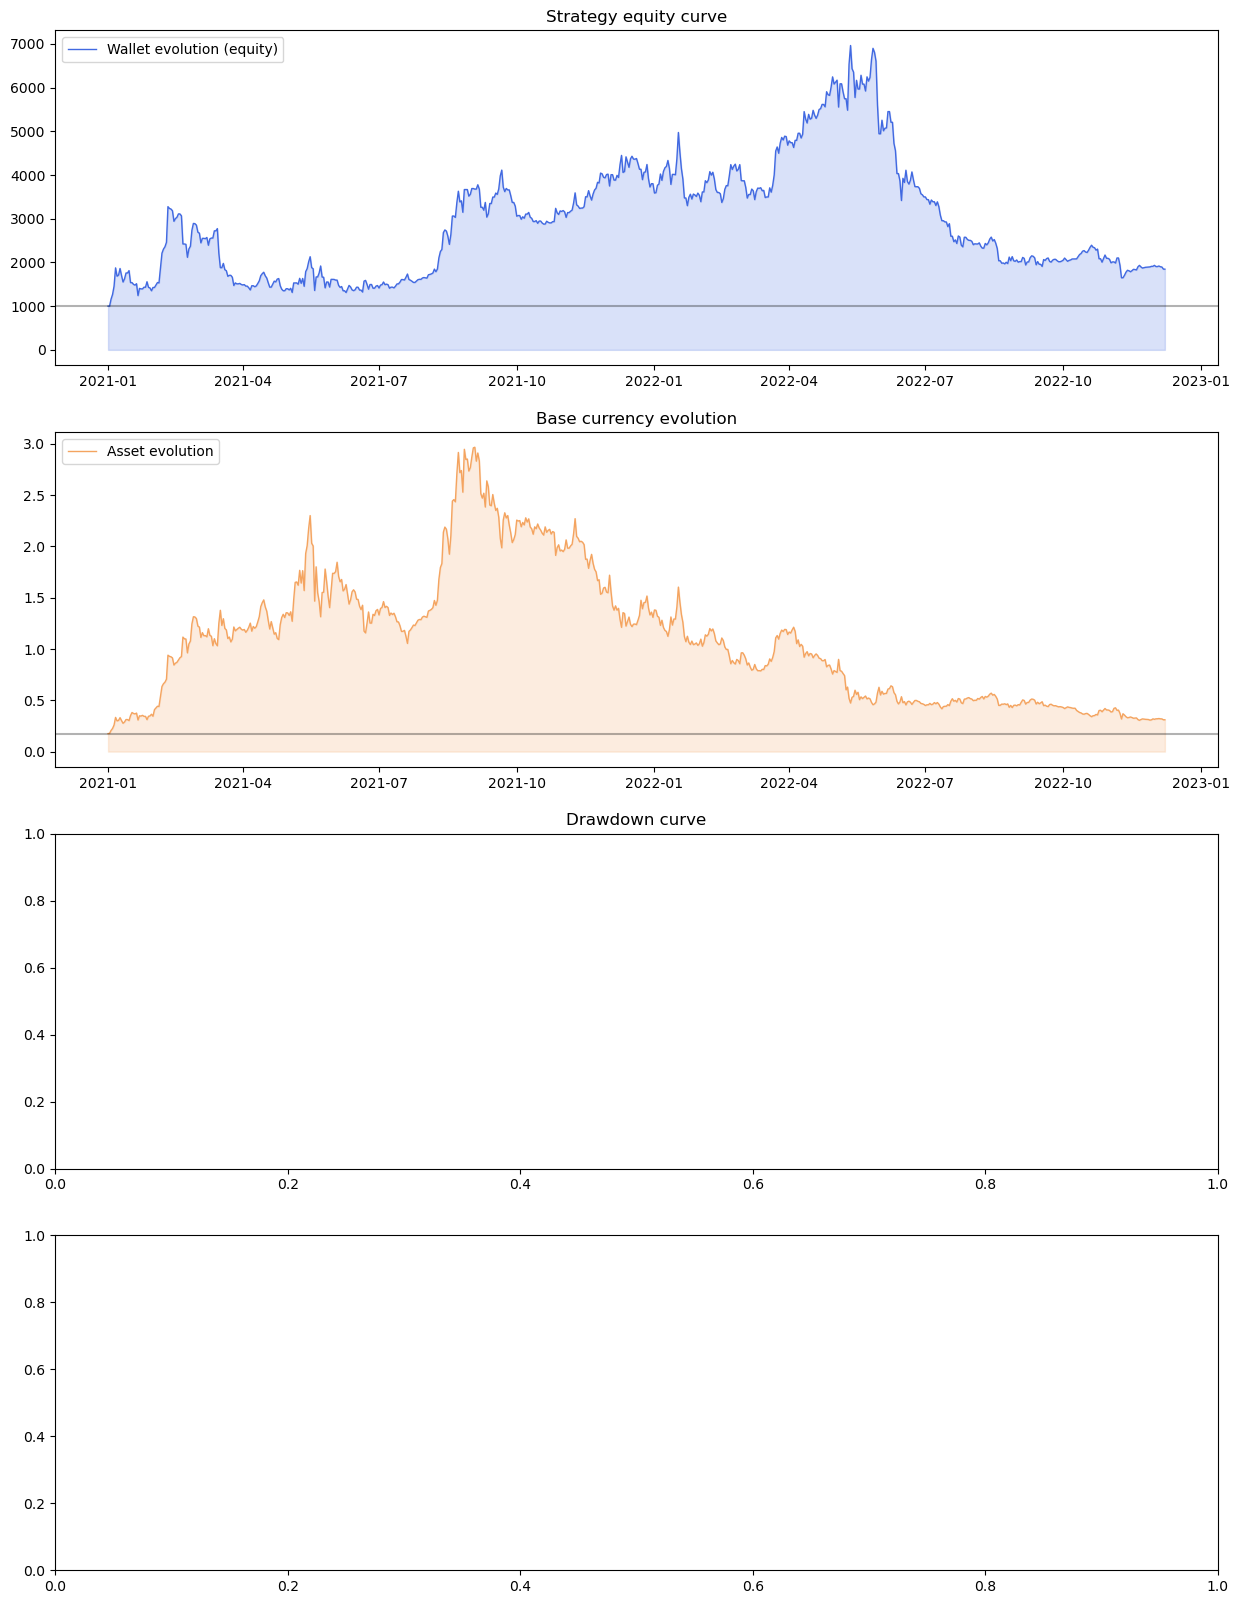

In [13]:
dt = df.copy().loc["2021":]

strat = lstm_strat(
    df = dt,
    use_short=True,
    strat=0,
)

strat.populate_indicators()
strat.populate_buy_sell(show_log=False)
bt_result = strat.run_backtest(initial_wallet=1000, return_type="metrics")
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days = bt_result['days'])
plot_wallet_vs_asset(df_days=bt_result['days'])

In [ ]:
dt = df.copy().loc["2021":]

strat = lstm_strat(
    df = dt,
    use_short=False,
    strat=1,
)

strat.populate_indicators()
strat.populate_buy_sell(show_log=True)
bt_result = strat.run_backtest(initial_wallet=1000, return_type="metrics")
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days = bt_result['days'])
plot_wallet_vs_asset(df_days=bt_result['days'])

: 